In [2]:
from __future__ import division

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

import datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
import string

%matplotlib inline

In [3]:
# NTEE file import to DF
df_ntee = pd.read_csv('NTEE_EINs_EOBMF.csv')


In [9]:
# split NTEE letter and code
letter = []
code = []
for i in df_ntee['NTEE'].values:
    try:
        letter.append(i[0])
        code.append(i[1:-1])
    except:
        letter.append('Null')
        code.append('Null')

df_ntee['letter'], df_ntee['code'] = letter, code

In [10]:
to_int = []
for i in df_ntee['EIN'].values:
    try:
        to_int.append(int(i.replace("-", "")))
    except:
        to_int.append(i)

df_ntee.drop('EIN', axis=1)
df_ntee['EIN'] = to_int

In [11]:
df_ntee.head()

,EIN,NTEE,letter,code
0,19818,NaN,Null,Null
1,29215,NaN,Null,Null
2,587764,X21,X,2
3,635913,X21,X,2
4,765634,X20,X,2


NTEE that appear less than 2 times: 33.33%
NTEE that appear less than 10 times: 66.05%
NTEE that appear less than 50 times: 81.03%
NTEE that appear less than 100 times: 85.78%
NTEE that appear less than 500 times: 94.1%


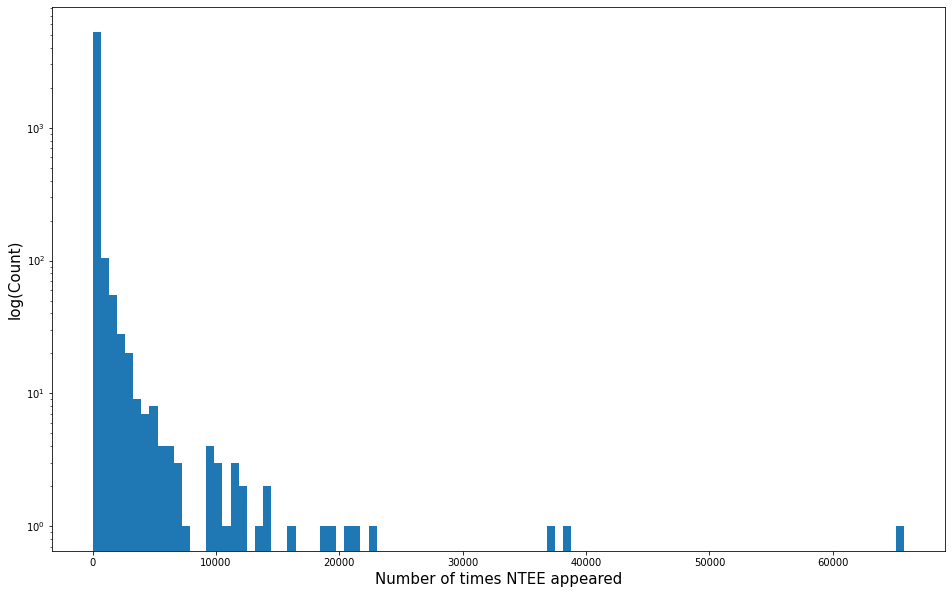

In [12]:
ntee_counts = df_ntee.groupby('NTEE')['NTEE'].count()

for i in [2, 10, 50, 100, 500]:
    print('NTEE that appear less than {} times: {}%'.format(i, round((ntee_counts < i).mean() * 100, 2)))

plt.figure(figsize=(16, 10))
plt.hist(ntee_counts.values, bins=100, log=True)
plt.xlabel('Number of times NTEE appeared', fontsize=15)
plt.ylabel('log(Count)', fontsize=15)
plt.show()

In [13]:
# NTEE counts in dataset
ntee_counts.sort_values(ascending=False)

NTEE
X20     65785
X21     38270
P20     37483
T20     22831
B82     21679
        ...  
J129        1
J124        1
J10         1
J050        1
000         1
Name: NTEE, Length: 5541, dtype: int64

Text(0, 0.5, 'Count')

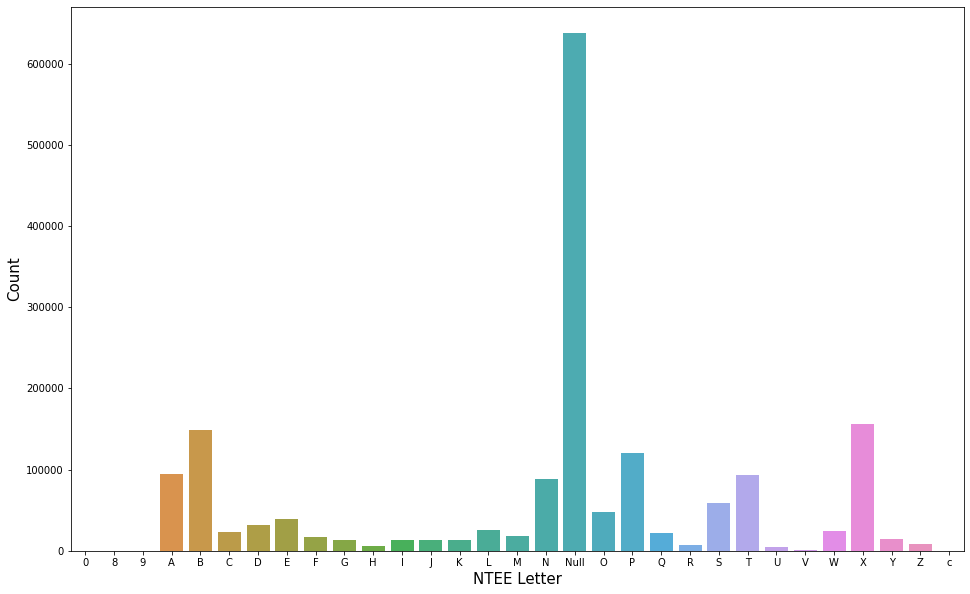

In [14]:
# NTEE letter counts
letter_counts = df_ntee.groupby('letter')['letter'].count()

plt.figure(figsize=(16, 10))
sns.barplot(letter_counts.index, letter_counts.values)
plt.xlabel('NTEE Letter', fontsize=15)
plt.ylabel('Count', fontsize=15)

In [15]:
# NTEE letter counts
letter_counts.sort_values(ascending=False)

letter
Null    637790
X       156122
B       149279
P       119934
A        94880
T        93737
N        88300
S        58804
O        47578
E        39197
D        32040
L        25626
W        24851
C        23184
Q        21910
M        18180
F        17612
Y        14804
K        13598
J        13208
G        12938
I        12818
Z         8780
R         7288
H         5622
U         4729
V         1542
0           11
c            3
9            1
8            1
Name: letter, dtype: int64

In [17]:
df_desc = pd.read_csv("../Sample_Program_Service_Data.csv", encoding="Windows-1252")
df_desc = df_desc.rename(columns={"NAME": "orgName", "DBA": "activityDesc", "MISSION": "missionDesc"})


In [19]:
# import descriptions file, combine useful text features into df_text
df_text = df_desc[['EIN', 'orgName','activityDesc','missionDesc','proj1Desc']]
df_text["text_blob"] = df_text["orgName"] + df_text["activityDesc"] + df_text["missionDesc"] + df_text["proj1Desc"]


In [20]:
# filter for text values only
df_text = df_text[df_text['text_blob'].apply(type)==str]

In [21]:
# cluster text with tf-idf and k-means
# tune max_df (document frequency): low values mean low overlap between clusters
def clusters_tfidf(df, feature, clusters_count = 25, num_terms = 10):
    vect = TfidfVectorizer(max_df = 0.02, max_features = None,
                                 stop_words = text.ENGLISH_STOP_WORDS.union(string.punctuation),
                                 use_idf = True, tokenizer = None, ngram_range=(1, 1))
    matrix = vect.fit_transform(df[feature]) 
    terms = vect.get_feature_names()
    km = KMeans(n_clusters = clusters_count, random_state=0)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    store = []
    for i in range(clusters_count):
        cluster_num = "Cluster %d:" % (i + 1)
        topics = ', '.join([terms[ind] for ind in order_centroids[i, :num_terms]])
        cluster_topics = cluster_num + ' ' + topics
        store.append(cluster_topics)
    return store

In [22]:
# e.g. for 10 clusters and 10 terms:

In [23]:
# e.g. 25 clusters and 15 terms:

In [24]:
df_merged = pd.merge(df_text, df_ntee, on='EIN', how='inner')

In [25]:
ntee_dict = { 
'B':[4],
'C':[12, 13, 14, 15, 16],
'F':[3],
'G':[3],
'H':[3],
'J':[8],
'K':[2],
'L':[1]}

In [26]:
sdg = []
for i in df_merged['letter'].values:
    try:
        sdg.append(ntee_dict[i])
    except:
        sdg.append([0])

In [27]:
df_merged['SDG'] = sdg

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer
y = df_merged.SDG
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [29]:
mlb.classes_

array([ 0,  1,  2,  3,  4,  8, 12, 13, 14, 15, 16])

In [30]:
SDG_dict = {0:"0: Unassigned",
            1:"1: No Poverty", 
            2:"2: Zero Hunger",
            3:"3: Good Health and Well-being",
            4:"4: Quality Education",
            5:"5: Gender Equality",
            6:"6: Clean Water and Sanitation",
            7:"7: Affordable and Clean Energy",
            8:"8: Decent Work and Economic Growth",
            9:"9: Industry, Innovation, and Infrastructure",
            10:"10: Reduced Inequalities",
            11:"11: Sustainable Cities and Communities",
            12:"12: Responsible Consumption and Production",
            13:"13: Climate Action",
            14:"14: Life Below Water",
            15:"15: Life on Land",
            16:"16: Peace, Justice, and Strong Institutions",
            17:"17: Partnerships for the Goals"}

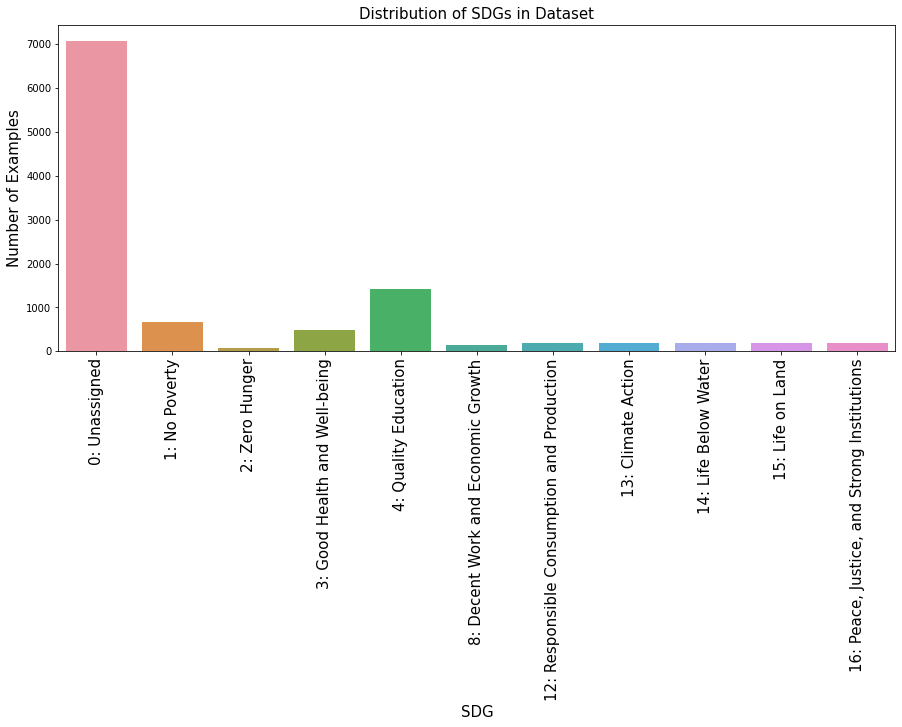

In [31]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation='vertical', fontsize = 15)
plt.title('Distribution of SDGs in Dataset', fontsize = 15)
plt.ylabel('Number of Examples', fontsize = 15)
plt.xlabel('SDG', fontsize = 15)
sns.barplot([SDG_dict[int(i)] for i in list(mlb.classes_)], y.sum(axis=0))